In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from sklearn.decomposition import PCA

In [2]:
from helper_funcs import *

In [3]:
data_latent_vec = np.load('../Data/latent_vecs2.npz')

In [4]:
list(data_latent_vec.keys())

['salient_vec_abide',
 'background_vec_abide',
 'vae_vec_abide',
 'salient_vec_sfari',
 'background_vec_sfari',
 'vae_vec_sfari']

In [5]:
salient_vec_abide = data_latent_vec['salient_vec_abide']
background_vec_abide = data_latent_vec['background_vec_abide']
vae_vec_abide = data_latent_vec['vae_vec_abide']
salient_vec_sfari = data_latent_vec['salient_vec_sfari']
background_vec_sfari = data_latent_vec['background_vec_sfari']
vae_vec_sfari = data_latent_vec['vae_vec_sfari']

In [6]:
def data2cmat(data):
    return np.array([squareform(pdist(data[s,:,:],metric='euclidean')) for s in range(data.shape[0])])

In [7]:
def plot_nice_bar(key,rsa,ax=None,figsize=None,dpi=None,fontsize=None,fontsize_star=None,fontweight=None,line_width=None,marker_size=None,title=None,report_t=False,do_pairwise_stars=True,do_one_sample_stars=True):
    #key = 'ADOS_gotham_PC1'
    import seaborn as sns
    from scipy.stats import ttest_1samp
    
    from scipy.stats import ttest_ind as ttest
    pallete = sns.color_palette()
    pallete_new = sns.color_palette()
    if not figsize:
        figsize = (5,2)
    if not dpi:
        dpi = 300
        
    if not ax:
        fig, ax = plt.subplots(1,1,figsize=figsize,dpi=dpi)

    pallete_new[1]=pallete[0]
    pallete_new[0]=pallete[1]
    pallete_new[0] = tuple(np.array((.5,.5,.5)))

    data=rsa[key]
    n = data.shape[0]
    c = data.shape[1]
    x = np.arange(c)
    
    if not fontsize:
        fontsize = 16
        
    if not fontsize_star:
        fontsize_star = 25
    if not fontweight:        
        fontweight = 'bold'
    if not line_width:    
        line_width = 2.5
    if not marker_size:            
        marker_size = .1
    


    for i in range(c):
        plot_data = np.zeros(data.shape)
        plot_data[:,i] = data[:,i]

        xs = np.repeat(i,n)+(np.random.rand(n)-.5)*.25
        sc = plt.scatter(xs,data[:,i],c='k',s = marker_size)
        b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))
        #sns.barplot(x=i,y=data.mean(axis=0)[i],errcolor='r',linewidth=2.5,facecolor=np.hstack((np.array(pallete_new[i]),.7)),edgecolor=np.hstack((np.array(pallete_new[i]),.7)))

    #xlbls = ['VAE','BG','SL']
    locs, labels = plt.yticks()  
    new_y = locs
    new_y = np.linspace(locs[0],locs[-1],6)
    plt.yticks(new_y,labels=[f'{yy:.2f}' for yy in new_y],fontsize=fontsize,fontweight=fontweight)
    plt.ylabel('model fit (r)',fontsize=fontsize,fontweight=fontweight)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(line_width)

    xlbls = ['VAE','BG','SL']
    plt.xticks(np.arange(3),labels=xlbls,fontsize=fontsize,fontweight=fontweight)


    #do_one_sample_stars = True
    if do_one_sample_stars:
        one_sample = np.array([ttest_1samp(data[:,i],0) for i in range(3)])
        one_sample_thresh = np.array((1,.05,.001,.0001))
        one_sample_stars = np.array(('n.s.','*','**','***'))
        xlbls = ['VAE','BG','SL']
        for i in range(c):
            these_stars = one_sample_stars[max(np.nonzero(one_sample[i,1]<one_sample_thresh)[0])]
            xlbls[i] = f'{xlbls[i]}\n({these_stars})'
        plt.xticks(np.arange(3),labels=xlbls,fontsize=fontsize,fontweight=fontweight,horizontalalignment='center',multialignment='center')

    pairwise_t = np.zeros((3,3))
    pairwise_p = np.zeros((3,3))

    pairwise_sample_thresh = np.array((1,.05,.001,.0001))
    pairwise_sample_stars = np.array(('n.s.','*','**','***'))

    if report_t:
        for i in range(c):
            for j in range(c):
                t,p = ttest(data[:,i],data[:,j])
                mnames = ['VAE','BG','SL']

                if p > .001:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p = {p:.2f}')
                else:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p $<$ .001')
                pairwise_t[i,j] = t
                pairwise_p[i,j] = p

    comps = [[1,2]]
    #do_pairwise_stars = True
    if do_pairwise_stars:
        for comp_idx in range(len(comps)):
            this_comp = comps[comp_idx]
            sig_idx = max(np.nonzero(pairwise_p[this_comp[0],this_comp[1]]<pairwise_sample_thresh)[0])
            max_y = new_y[-1] + comp_idx*.05
            xs = np.array(this_comp)
            stars = pairwise_sample_stars[sig_idx]
            plt.plot(xs,[max_y,max_y],'k',linewidth=line_width)
            plt.text(xs.mean(),max_y,stars,fontsize=fontsize_star,horizontalalignment='center',fontweight=fontweight)
        
    #plt.plot(plt.xlim(),[0,0],'k',linewidth=line_width)
    ylim = plt.ylim()
    plt.ylim(np.array(ylim)*(1,1.1))
        
    #plt.xlabel(key,fontsize=fontsize,labelpad=25.1,fontweight=fontweight)    
    
    if not title:
        plt.title(key,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)    
    else:
        plt.title(title,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)

In [8]:
cmat_salient_vec_abide = data2cmat(salient_vec_abide)
cmat_background_vec_abide = data2cmat(background_vec_abide)
cmat_vae_vec_abide = data2cmat(vae_vec_abide)
cmat_salient_vec_sfari = data2cmat(salient_vec_sfari)
cmat_background_vec_sfari = data2cmat(background_vec_sfari)
cmat_vae_vec_sfari = data2cmat(vae_vec_sfari)

In [9]:
dataFnOut = '../Data/ABIDE-Anat-64iso-S982.npz'
dfFnOut = '../Data/ABIDE_legend_S982.csv'

ABIDE_data = np.load(dataFnOut)['data']
df = pd.read_csv(dfFnOut)

patients = df['DxGroup'].values==1
controls = df['DxGroup'].values==2
abide_asd = ABIDE_data[patients,:,:,:]

arr = np.load('../Data/SFARI-Anat-64iso-S121.npz')
dfs = pd.read_csv('../Data/sfari_legend_S121.csv')

SFARI_data = arr['data']
SFARI_subs = arr['subs']

sfari_subs_td = dfs['family_type'].values=='non-familial-control'
sfari_subs_dupl = dfs['family_type'].values=='16p-duplication'
sfari_subs_del = dfs['family_type'].values=='16p-deletion'

In [10]:
ABIDE_subs = np.load('../Data/ABIDE-subs-982.npz')['subs']
SFARI_subs = arr['subs']

In [11]:
assert len(df['BIDS_ID'].values)==len(ABIDE_subs), 'diff lengths'
assert all([df['BIDS_ID'].values[s]==ABIDE_subs[s] for s in range(len(ABIDE_subs))]), 'diff order'

In [12]:
#df['random'] = np.random.rand(len(df))*10

## ABIDE

In [13]:
%time
# ABIDE MAKE MODELS 
plt.figure(figsize=(15,15))
default_keys = ['ADOS_Total','ADOS_Social','DSMIVTR','AgeAtScan','Sex','ScannerID','ScanSiteID','FIQ']
scales_ = ['ratio','ratio','ordinal','ratio','ordinal','ordinal','ordinal','ratio','ratio','ratio']

model_rdms = dict()
model_idxs = dict()
for i in range(len(default_keys)):
    #plt.subplot(4,4,i+1);
    inVec = df[default_keys[i]].values[patients];
    idx = ~np.isnan(inVec)
    inVec = inVec[idx];
    this_rdm = make_RDM(inVec,data_scale=scales_[i])
    #sns.heatmap(this_rdm,cbar=[],xticklabels=[],yticklabels=[]);
    #plt.title(default_keys[i]);
    
    model_rdms.update({default_keys[i] : this_rdm})
    model_idxs.update({default_keys[i] : idx})

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.81 µs


<Figure size 1080x1080 with 0 Axes>

In [14]:
def slice_cmat(data,idx):
    mat = data[patients,:][:,patients]
    mat = mat[idx,:][:,idx]
    return mat

In [15]:
def fit_rsa(data,key):
    #corr = scipy.stats.stats.pearsonr
    corr = scipy.stats.stats.kendalltau
    r = np.array([corr(get_triu(slice_cmat(data[i,:,:],model_idxs[key])),get_triu(model_rdms[key]))[0] for i in range(10)])
    r = np.arctan(r)
    return r

# PCA SCORES

In [16]:
# ABIDE FIT MODELS 
patients = df['DxGroup'].values==1

data = [cmat_vae_vec_abide,cmat_background_vec_abide,cmat_salient_vec_abide]

rsa_results = dict()
for key in default_keys:
    res = np.array([fit_rsa(datum,key) for datum in data]).transpose()
    rsa_results.update({key : res})
    
    
# PCA RSA
keys_pca = {}
keys_pca.update({'ADOS_PCA' :  ['ADOS_Total','ADOS_Comm', 'ADOS_Social', 'ADOS_StBeh']})
keys_pca.update({'ADI_PCA' :   ['ADI_R_SocialTotal', 'ADI_R_VerbalTotal', 'ADI_R_RRB','ADI_R_Onset Total']})
keys_pca.update({'Vineland_PCA' :   ['VINELAND_Receptive_Vscore',
 'VINELAND_Expressive_Vscore',
 'VINELAND_Written_Vscore',
 'VINELAND_CommunicationStandard',
 'VINELAND_Personal_Vscore',
 'VINELAND_Domestic_Vscore',
 'VINELAND_Community_Vscore',
 'VINELAND_DaylyLiving_Standard',
 'VINELAND_Interpersonal_Vscore',
 'VINELAND_Play_Vscore',
 'VINELAND_Coping_Vscore',
 'VINELAND_Socical_Standard',
 'VINELAND_Domestic_Standard',
 'VINELAND_ABC_Standard',
 'VINELAND_Informant']})
keys_pca.update({'WISC_PCA' :  ['WISC4 VCI Verbal Comprehension Index',
       'WISC4 PRI Perceptual Reasoning Index',
       'WISC4 WMI Working Memory Index', 'WISC4 PSI Processing Speed Index',
       'WISC4 Sim Scaled', 'WISC4 Vocab Scaled', 'WISC4 Info Scaled',
       'WISC4 Blk Dsn Scaled', 'WISC4 Pic Con Scaled', 'WISC4 Matrix Scaled',
       'WISC4 Dig Span Scaled', 'WISC4 Let Num Scaled', 'WISC4 Coding Scaled',
       'WISC4 Sym Scaled']})
# keys_pca.update({'' :   []})


# Calculate PCA RSA
pca_keys = list(keys_pca.keys())
model_pcas = dict()
for key in pca_keys:
    arr = np.array(df[keys_pca[key]])
    arr = arr[patients,:]

    idx = ~np.isnan(arr.mean(axis=1))
    mat = arr[idx,:]

    pca = PCA(n_components=1)
    pca_vec = pca.fit_transform(mat)
    rdm = make_RDM(pca_vec)
    model_rdms.update({key : rdm})
    model_idxs.update({key : idx})
    model_pcas.update({key : pca_vec})
    #model_idxs.update({key : pca.fit_transform(mat)})
    

    res = np.array([fit_rsa(datum,key) for datum in data]).transpose()
    rsa_results.update({key : res})
    
    df[key] = 0
    for i_rel,i_abs in enumerate(np.nonzero(model_idxs[key])[0]):
        #df[key].values[i_abs] = model_pcas[key][i_rel]
        df[key].values[np.nonzero(patients)[0][i_abs]] = model_pcas[key][i_rel]

In [17]:
df.to_csv('../Data/ABIDE_legend_S982_pca.csv')

## SFARI

In [18]:
# data = SFARI_data
patients = sfari_subs_dupl+sfari_subs_del

In [19]:
%time
# SFARI
plt.figure(figsize=(15,15))
# default_keys = ['ADOS_Total','ADOS_Social','DSMIVTR','AgeAtScan','Sex','ScannerID','ScanSiteID','FIQ']
# scales_ = ['ratio','ratio','ordinal','ratio','ordinal','ordinal','ordinal','ratio','ratio','ratio']

default_keys = ['best_full_scale_iq','rrb_css','sa_css','age_years', 'ord_diagnosis',
       'ord_gene', 'ord_sex','ord_scanner']
scales_ = [None,None,None,None,'ordinal','ordinal','ordinal','ordinal']

#model_rdms = dict()
#model_idxs = dict()
for i in range(8):
    #plt.subplot(4,4,i+1);
    inVec = dfs[default_keys[i]].values[patients];
    idx = ~np.isnan(inVec)
    inVec = inVec[idx];
    this_rdm = make_RDM(inVec,data_scale=scales_[i])
    #sns.heatmap(this_rdm,cbar=[],xticklabels=[],yticklabels=[]);
    #plt.title(default_keys[i]);
    
    model_rdms.update({default_keys[i] : this_rdm})
    model_idxs.update({default_keys[i] : idx})

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


<Figure size 1080x1080 with 0 Axes>

In [20]:
# SFARI FIT MODELS 
data = [cmat_vae_vec_sfari,cmat_background_vec_sfari,cmat_salient_vec_sfari]
#rsa_results = dict()
for key in default_keys:
    res = np.array([fit_rsa(datum,key) for datum in data]).transpose()
    rsa_results.update({key : res})

In [21]:
keys = list(rsa_results.keys())
keys

['ADOS_Total',
 'ADOS_Social',
 'DSMIVTR',
 'AgeAtScan',
 'Sex',
 'ScannerID',
 'ScanSiteID',
 'FIQ',
 'ADOS_PCA',
 'ADI_PCA',
 'Vineland_PCA',
 'WISC_PCA',
 'best_full_scale_iq',
 'rrb_css',
 'sa_css',
 'age_years',
 'ord_diagnosis',
 'ord_gene',
 'ord_sex',
 'ord_scanner']

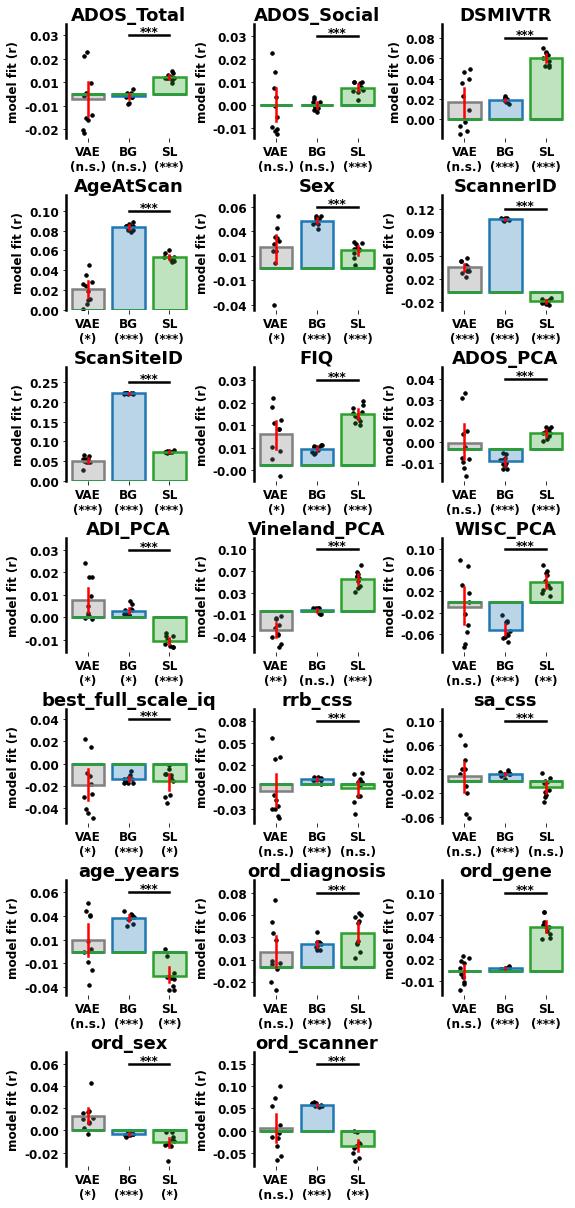

In [22]:
ncols = 3
nrows = int(np.ceil(len(keys)/3))

plt.figure(figsize=np.array((ncols,nrows))*3)

for i,key in enumerate(keys):
    ax = plt.subplot(nrows,ncols,i+1)
    plot_nice_bar(key,rsa_results,
                  ax=ax,figsize=None,
                  dpi=300,fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12)
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

#plt.savefig('../figures/RSA_barplots_newData2.png')

In [23]:
res = rsa_results['DSMIVTR']

DSMIVTR VAE >  VAE | t(9) = 0.00 p = 1.00
DSMIVTR VAE >  BG | t(9) = -0.30 p = 0.77
DSMIVTR VAE >  SL | t(9) = -5.35 p $<$ .001
DSMIVTR BG >  VAE | t(9) = 0.30 p = 0.77
DSMIVTR BG >  BG | t(9) = 0.00 p = 1.00
DSMIVTR BG >  SL | t(9) = -19.86 p $<$ .001
DSMIVTR SL >  VAE | t(9) = 5.35 p $<$ .001
DSMIVTR SL >  BG | t(9) = 19.86 p $<$ .001
DSMIVTR SL >  SL | t(9) = 0.00 p = 1.00


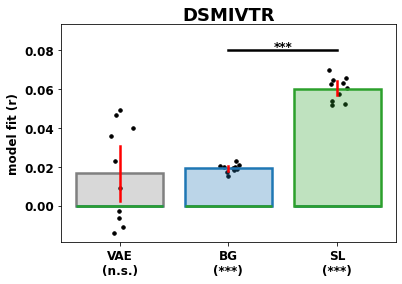

In [24]:
key = 'DSMIVTR'
plot_nice_bar(key,rsa_results,
              ax=ax,figsize=None,
              dpi=300,fontsize=12,
              fontsize_star=12,
              fontweight='bold',
              line_width=2.5,
              marker_size=12,report_t=True)

In [25]:
list(rsa_results.keys())

['ADOS_Total',
 'ADOS_Social',
 'DSMIVTR',
 'AgeAtScan',
 'Sex',
 'ScannerID',
 'ScanSiteID',
 'FIQ',
 'ADOS_PCA',
 'ADI_PCA',
 'Vineland_PCA',
 'WISC_PCA',
 'best_full_scale_iq',
 'rrb_css',
 'sa_css',
 'age_years',
 'ord_diagnosis',
 'ord_gene',
 'ord_sex',
 'ord_scanner']

In [26]:
#key = 'DSMIVTR'
#data = rsa_results[key]
    
def plot_rsa_bar(data,key):
    import scipy
    import seaborn as sns
    ttest_1samp = scipy.stats.ttest_1samp
    ttest_rel = scipy.stats.ttest_rel    
    
    # Calculate Plotting data
    c = data.shape[1]
    n = data.shape[0]
    xs = np.arange(c)
    xlbls = ['VAE','BG','SL']

    m = data.mean(axis=0)
    sd = data.std(axis=0)
    
    # T statistics
    t_1samp = np.array([ttest_1samp(data[:,i],0)[0] for i in range(c)])
    p_1samp = np.array([ttest_1samp(data[:,i],0)[1] for i in range(c)])

    p_paired_t = np.zeros((c,c))
    t_paired_t = np.zeros((c,c))

    # Bar, Errorbar, Scatter 
    for i in range(c):
        for j in range(c):
            t_paired_t[i,j] = ttest_rel(data[:,i],data[:,j])[0]
            p_paired_t[i,j] = ttest_rel(data[:,i],data[:,j])[1]
            
    if p_paired_t[2,1] < .001:
        print(f'{key} {xlbls[2]} > {xlbls[1]}: t({data.shape[0]-1}) = {t_paired_t[2,1].round(2)}, p $<$ .001')
    else:
        print(f'{key} {xlbls[2]} > {xlbls[1]}: t({data.shape[0]-1}) = {t_paired_t[2,1].round(2)}, p = {p_paired_t[2,1].round(3)}')
        
    if p_paired_t[1,2] < .001:
        print(f'{key} {xlbls[1]} > {xlbls[2]}: t({data.shape[0]-1}) = {t_paired_t[1,2].round(2)}, p $<$ .001')
    else:
        print(f'{key} {xlbls[1]} > {xlbls[2]}: t({data.shape[0]-1}) = {t_paired_t[1,2].round(2)}, p = {p_paired_t[1,2].round(3)}')

    # Plotting
    fig, ax = plt.subplots(1,1)
    pallete = sns.color_palette()
    pallete_new = sns.color_palette()
    pallete_new[1]=pallete[0]
    pallete_new[0]=pallete[1]
    pallete_new[0] = tuple(np.array((.5,.5,.5)))

    linewidth = 3
    fontsize = 14
    fontweight='bold'
    for i in range(3):
        plt.bar(xs[i],m[i],edgecolor=np.hstack((pallete_new[i],1)),
                facecolor=np.hstack((pallete_new[i],.5)),
                linewidth=linewidth)

        plt.errorbar(xs[i],m[i],sd[i],fmt='r ',linewidth=linewidth)
        plt.scatter(x=(np.repeat(i,n)+(np.random.rand(n)-.5)*.25),y=data[:,i],
                   s=fontsize*3,
                   c='k')



    t_thresh = np.array((1,.05,.001,.0001));
    t_stars = np.array(('n.s.','*','**','***'));
    star_idx = (np.nonzero((p_paired_t[2,1] < t_thresh))[0]).max();
    plt.plot([1,2],np.repeat(data.max(),2)*1.25,'k',linewidth=linewidth);
    plt.text(1.4,data.max()*1.25+.002,t_stars[star_idx],fontsize=fontsize*1.25,fontweight='bold');

    ax.spines['top'].set_visible(False);
    ax.spines['right'].set_visible(False);
    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(linewidth);

    xlabels = ['VAE','BG','SL'];
    one_sample_star_idx = [(np.nonzero((p_1samp[ii] < t_thresh))[0]).max() for ii in range(c)];
    xlabels = [f'{xlabels[ii]}\n({t_stars[one_sample_star_idx[ii]]})' for ii in range(c)];

    #xticks = np.linspace(data.min().round(2),data.max().round(2),5)
    #plt.yticks(xticks,labels=[str(ii) for ii in xticks],fontsize=fontsize)
    plt.yticks(fontsize=fontsize,fontweight=fontweight);
    plt.xticks(xs,xlabels,fontsize=fontsize,fontweight=fontweight);
    plt.title(key,fontweight=fontweight,fontsize=fontsize*1.25,pad=fontsize)

In [27]:
xlbls = ['VAE','BG','SL']
t_paired_t = np.random.rand(3,3)
p_paired_t = np.random.rand(3,3)

In [28]:
#f'{xlbls[1]} > {xlbls[2]}: t({data.shape[0]-1}) = {t_paired_t[1,2].round(2)}, p = {t_paired_t[1,2].round(3)}'

ADOS_Total SL > BG: t(9) = 11.59, p $<$ .001
ADOS_Total BG > SL: t(9) = -11.59, p $<$ .001
ADOS_Social SL > BG: t(9) = 8.64, p $<$ .001
ADOS_Social BG > SL: t(9) = -8.64, p $<$ .001
DSMIVTR SL > BG: t(9) = 20.04, p $<$ .001
DSMIVTR BG > SL: t(9) = -20.04, p $<$ .001
AgeAtScan SL > BG: t(9) = -24.11, p $<$ .001
AgeAtScan BG > SL: t(9) = 24.11, p $<$ .001
Sex SL > BG: t(9) = -11.9, p $<$ .001
Sex BG > SL: t(9) = 11.9, p $<$ .001
ScannerID SL > BG: t(9) = -124.83, p $<$ .001
ScannerID BG > SL: t(9) = 124.83, p $<$ .001
ScanSiteID SL > BG: t(9) = -172.26, p $<$ .001
ScanSiteID BG > SL: t(9) = 172.26, p $<$ .001
FIQ SL > BG: t(9) = 12.86, p $<$ .001
FIQ BG > SL: t(9) = -12.86, p $<$ .001
ADOS_PCA SL > BG: t(9) = 12.73, p $<$ .001
ADOS_PCA BG > SL: t(9) = -12.73, p $<$ .001
ADI_PCA SL > BG: t(9) = -14.7, p $<$ .001
ADI_PCA BG > SL: t(9) = 14.7, p $<$ .001
Vineland_PCA SL > BG: t(9) = 10.46, p $<$ .001
Vineland_PCA BG > SL: t(9) = -10.46, p $<$ .001
WISC_PCA SL > BG: t(9) = 9.49, p $<$ .001
W

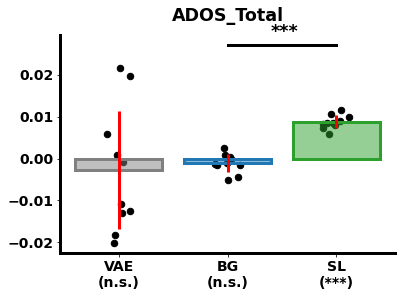

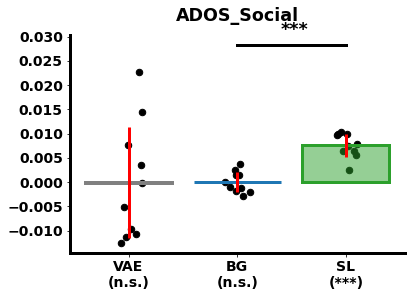

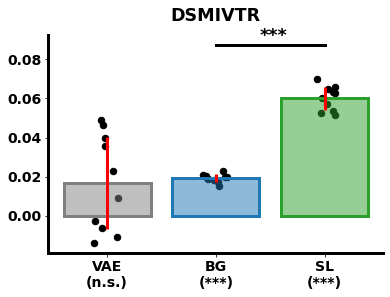

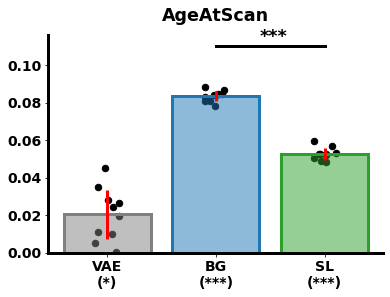

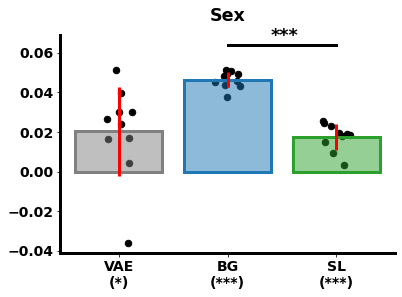

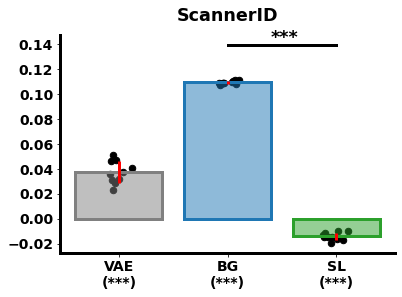

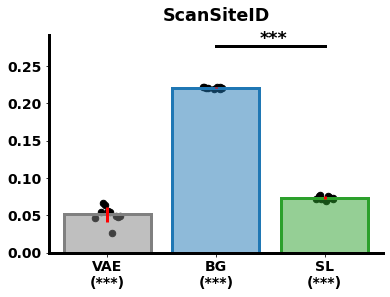

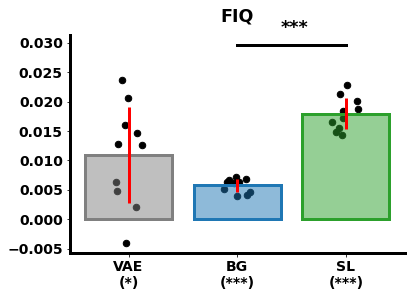

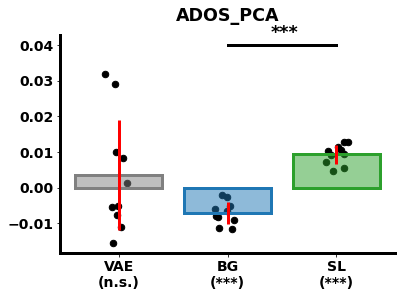

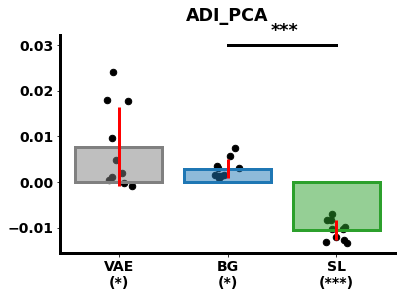

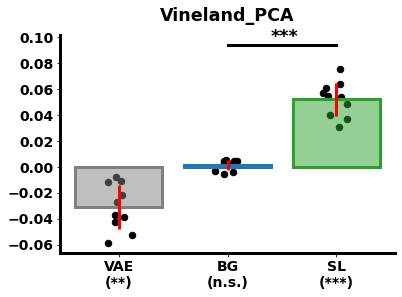

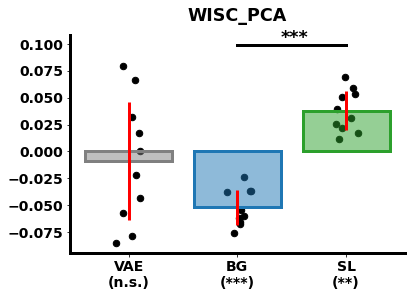

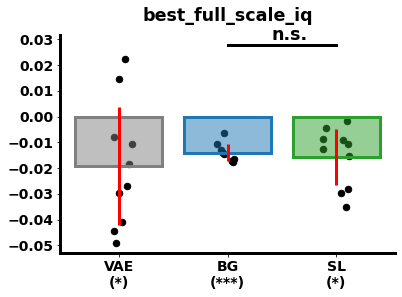

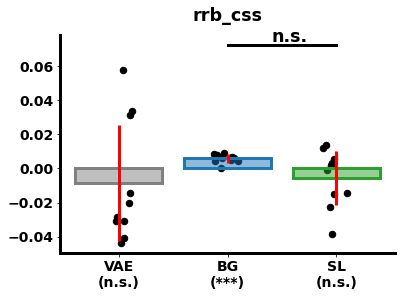

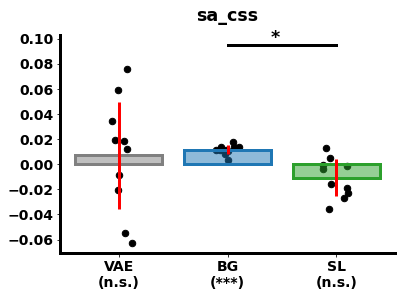

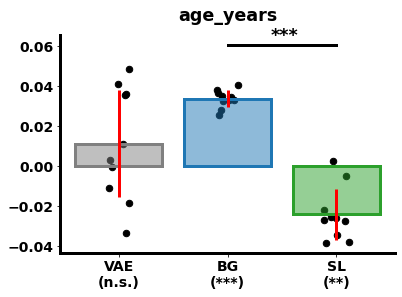

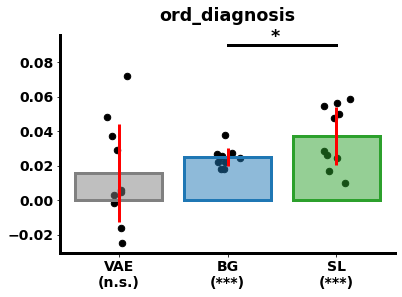

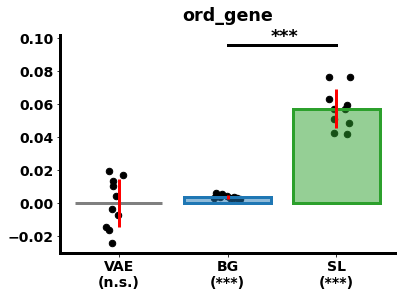

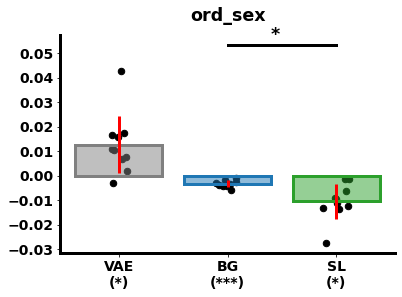

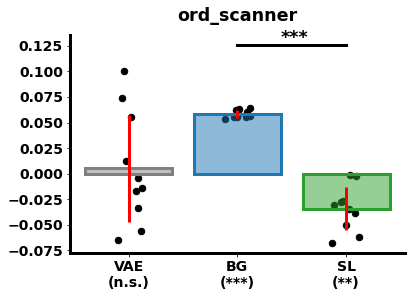

In [29]:
keys = list(rsa_results.keys())
for key in keys:
    data = rsa_results[key]
    plot_rsa_bar(data,key)
    plt.savefig('/Users/aidasaglinskas/Desktop/bars/'+key+'.pdf')

In [30]:
#key = 'DSMIVTR'
#data = rsa_results[key]
    
def plot_rsa_bar2(data,key):
    import scipy
    import seaborn as sns
    #ttest_1samp = scipy.stats.ttest_1samp
    #ttest_rel = scipy.stats.ttest_rel    
    
    # Calculate Plotting data
    c = data.shape[1]
    n = data.shape[0]
    xs = np.arange(c)
    xlbls = ['VAE','BG','SL']

    m = data.mean(axis=0)
    sd = data.std(axis=0)
    
    fig, ax = plt.subplots(1,1)
    pallete = sns.color_palette()
    pallete_new = sns.color_palette()
    pallete_new[1]=pallete[0]
    pallete_new[0]=pallete[1]
    pallete_new[0] = tuple(np.array((.5,.5,.5)))

    linewidth = 3
    fontsize = 14
    fontweight='bold'
    for i in range(3):
        plt.bar(xs[i],m[i],edgecolor=np.hstack((pallete_new[i],1)),
                facecolor=np.hstack((pallete_new[i],.5)),
                linewidth=linewidth)

        plt.errorbar(xs[i],m[i],sd[i],fmt='r ',linewidth=linewidth)
        plt.scatter(x=(np.repeat(i,n)+(np.random.rand(n)-.5)*.25),y=data[:,i],
                   s=fontsize*3,
                   c='k')

    ax.spines['top'].set_visible(False);
    ax.spines['right'].set_visible(False);
    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(linewidth);

    xlabels = ['VAE','BG','SL'];
    
    plt.yticks(fontsize=fontsize,fontweight=fontweight);
    plt.xticks(xs,xlabels,fontsize=fontsize,fontweight=fontweight);
    plt.title(key,fontweight=fontweight,fontsize=fontsize*1.25,pad=fontsize)
    
    ## Delta
    
    
    

In [31]:
keys = ['DSMIVTR',
 'AgeAtScan',
 'Sex',
 'ScannerID',
 'FIQ',
 'ADOS_PCA',
 'ADI_PCA',
 'Vineland_PCA',
 'WISC_PCA',]

In [32]:
#rsa_results['Vineland_PCA']
model_rdms['FIQ'].shape

(428, 428)

In [33]:
#list(rsa_results.keys())

In [34]:
key

'ord_scanner'

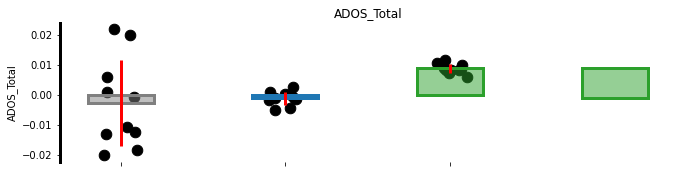

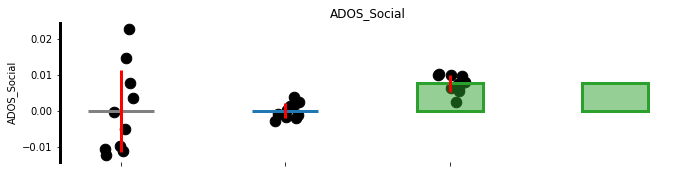

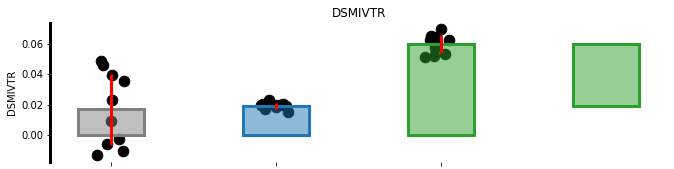

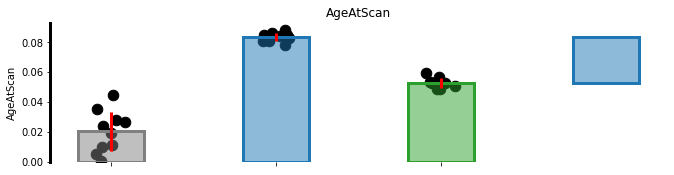

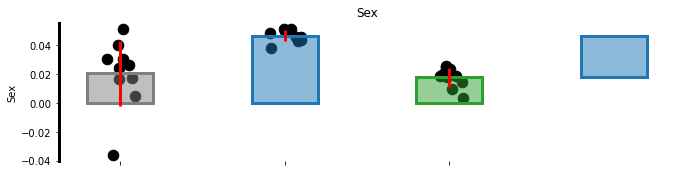

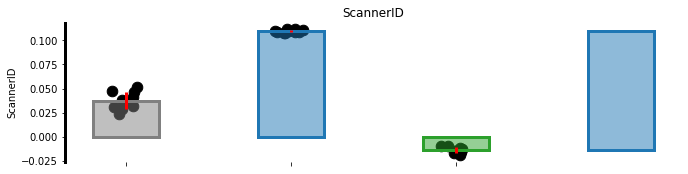

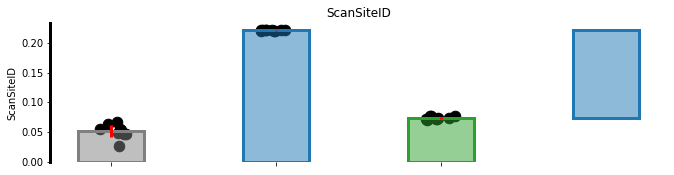

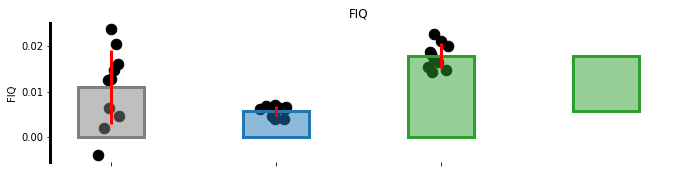

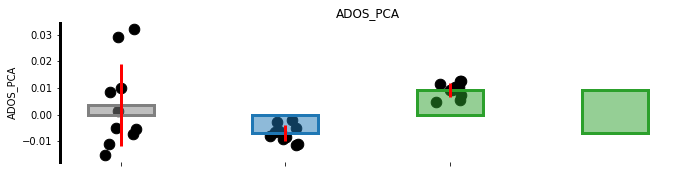

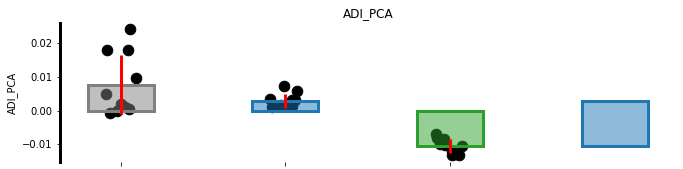

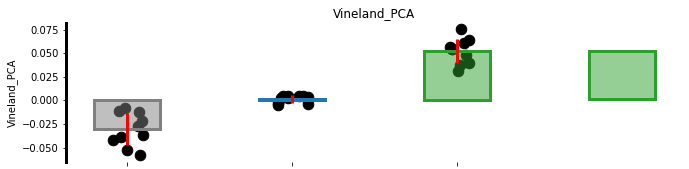

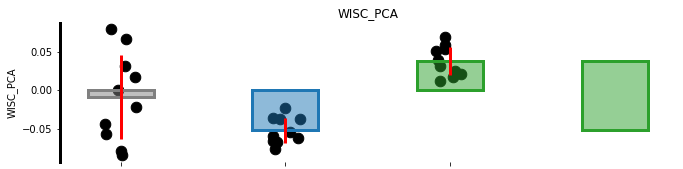

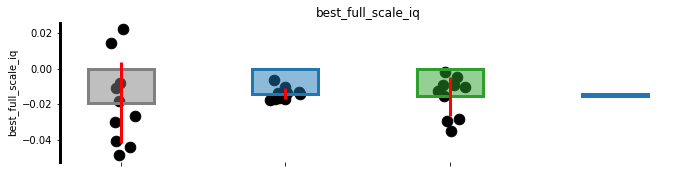

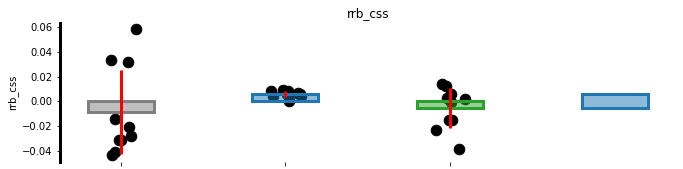

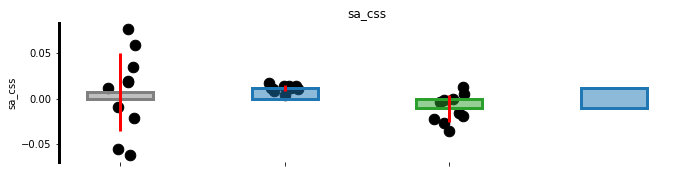

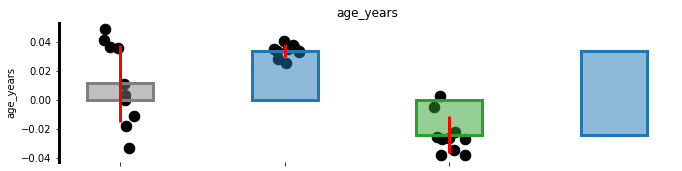

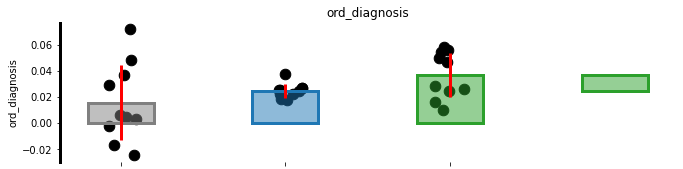

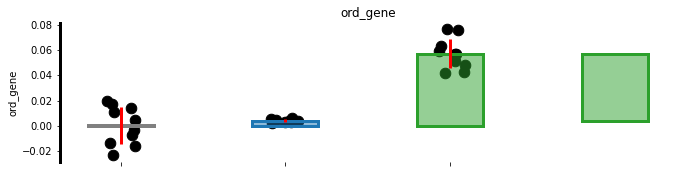

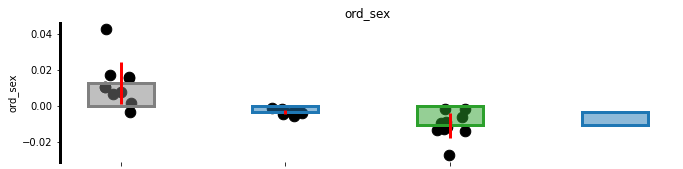

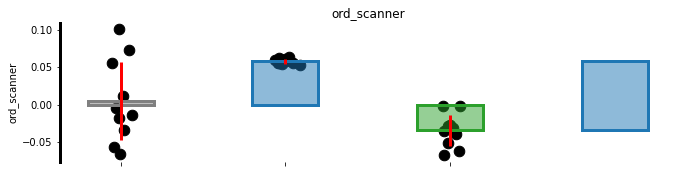

In [35]:
#key = keys[1]
#key = 'ScannerID'
keys = rsa_results.keys()
for key in keys:
    data = rsa_results[key]

    #plt.figure(figsize=(10,5))
    # Calculate Plotting data
    c = data.shape[1]
    n = data.shape[0]
    #xs = np.arange(c)
    spacing = 5
    xs = np.array([1,2,3])*spacing
    xlbls = ['VAE','BG','SL']

    m = data.mean(axis=0)
    sd = data.std(axis=0)

    fig, ax = plt.subplots(1,1,figsize=np.array((13,3))*.85)
    pallete = sns.color_palette()
    pallete_new = sns.color_palette()
    pallete_new[1]=pallete[0]
    pallete_new[0]=pallete[1]
    pallete_new[0] = tuple(np.array((.5,.5,.5)))

    linewidth = 3
    fontsize = 16
    fontweight='bold'
    barwidth = 2
    for i in range(3):
        plt.bar(xs[i],m[i],width=barwidth,edgecolor=np.hstack((pallete_new[i],1)),
                facecolor=np.hstack((pallete_new[i],.5)),
                linewidth=linewidth)

        plt.errorbar(xs[i],m[i],sd[i],fmt='r ',linewidth=linewidth)
        plt.scatter(x=(np.repeat(xs[i],n)+(np.random.rand(n)-.5)*1),y=data[:,i],
                   s=fontsize*7,
                   c='k')

    ax.spines['top'].set_visible(False);
    ax.spines['right'].set_visible(False);
    ax.spines['bottom'].set_visible(False);
    #ax.spines['bottom'].set_position(('data', 0))

    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(linewidth);

    xlabels = ['VAE','BG','SL'];

    #plt.yticks(fontsize=fontsize,fontweight=fontweight,rotation=90+45);
    plt.xticks(xs,[],fontsize=fontsize,fontweight=fontweight,rotation=90);
    plt.ylabel(key)
    #plt.title(key,fontweight=fontweight,fontsize=fontsize*1.25,pad=fontsize)


    ## PLOT DELTA
    ## IF BLUE > GREEN 
    xx = 4*spacing

    if m[1]>m[2]:
        plt.bar(xx,m[2]-m[1],bottom=m[1],width=barwidth,edgecolor=np.hstack((pallete_new[1],1)),
                    facecolor=np.hstack((pallete_new[1],.5)),
                    linewidth=linewidth)

        #plt.plot([xs[1]+barwidth/2,xx-barwidth/2],[m[1],m[1]],'k--')
        #plt.plot([xs[2]+barwidth/2,xx-barwidth/2],[m[2],m[2]],'k--')
    #     plt.scatter(x=(np.repeat(xx,n)+(np.random.rand(n)-.5)*.25),y=data[:,1]-data[:,2],
    #                s=fontsize*7,
    #                c='k')


    else:
        plt.bar(xx,m[1]-m[2],bottom=m[2],width=barwidth,edgecolor=np.hstack((pallete_new[2],1)),
                facecolor=np.hstack((pallete_new[2],.5)),
                linewidth=linewidth)

        #plt.plot([xs[2]+barwidth/2,xx-barwidth/2],[m[2],m[2]],'k--')
        #plt.plot([xs[1]+barwidth/2,xx-barwidth/2],[m[1],m[1]],'k--')
    #     plt.scatter(x=(np.repeat(xx,n)+(np.random.rand(n)-.5)*.25),y=data[:,2]-data[:,1],
    #                s=fontsize*7,
    #                c='k')

    #plt.xticks([])
    #plt.yticks([])
    plt.title(key)
    #plt.ylim([0,.1])
    #plt.ylabel()
    #plt.tight_layout()
    #plt.savefig('/Users/aidasaglinskas/Desktop/bars/'+key+'.pdf')

In [36]:
keys

dict_keys(['ADOS_Total', 'ADOS_Social', 'DSMIVTR', 'AgeAtScan', 'Sex', 'ScannerID', 'ScanSiteID', 'FIQ', 'ADOS_PCA', 'ADI_PCA', 'Vineland_PCA', 'WISC_PCA', 'best_full_scale_iq', 'rrb_css', 'sa_css', 'age_years', 'ord_diagnosis', 'ord_gene', 'ord_sex', 'ord_scanner'])

In [37]:
keys

dict_keys(['ADOS_Total', 'ADOS_Social', 'DSMIVTR', 'AgeAtScan', 'Sex', 'ScannerID', 'ScanSiteID', 'FIQ', 'ADOS_PCA', 'ADI_PCA', 'Vineland_PCA', 'WISC_PCA', 'best_full_scale_iq', 'rrb_css', 'sa_css', 'age_years', 'ord_diagnosis', 'ord_gene', 'ord_sex', 'ord_scanner'])

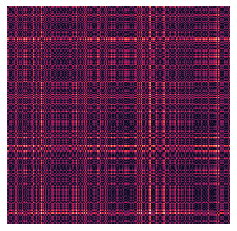

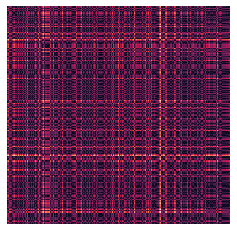

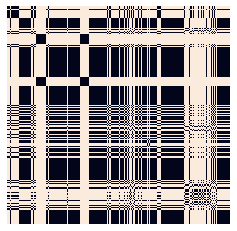

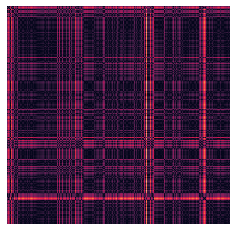

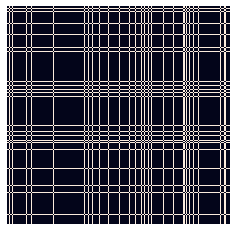

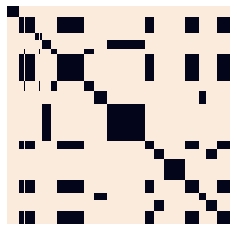

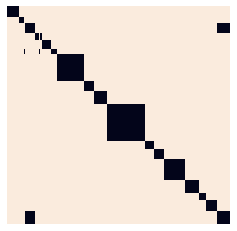

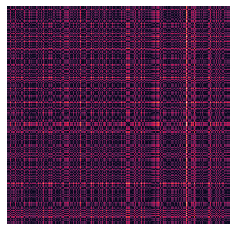

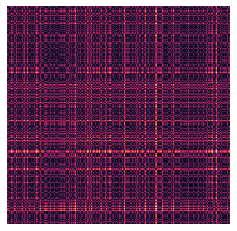

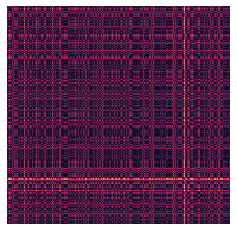

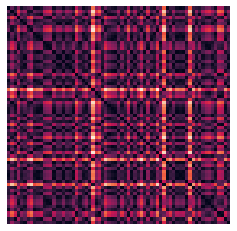

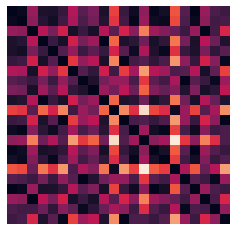

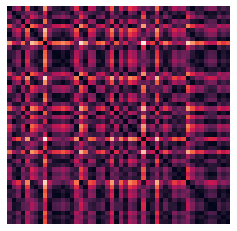

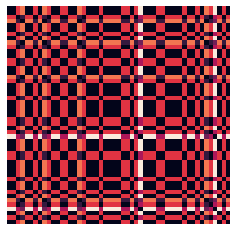

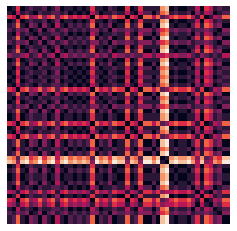

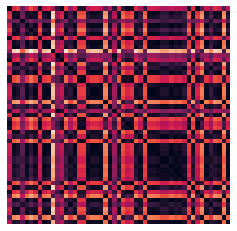

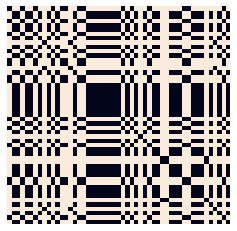

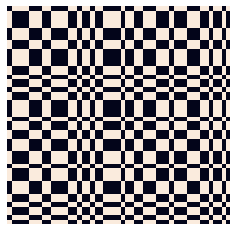

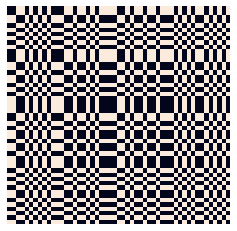

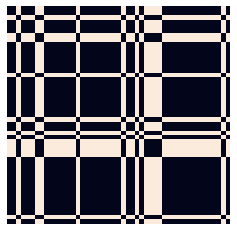

In [38]:
for key in keys:
    plt.figure(figsize=(4,4))
    sns.heatmap(model_rdms[key],xticklabels=[],yticklabels=[],cbar=False)
    plt.savefig('/Users/aidasaglinskas/Desktop/bars/'+'rdm_'+key+'.png')

In [39]:
abide_patients = df['DxGroup'].values==1
cmats = [cmat_vae_vec_abide[0,:,:][:,abide_patients][abide_patients,:],
        cmat_background_vec_abide[0,:,:][:,abide_patients][abide_patients,:],
        cmat_salient_vec_abide[0,:,:][:,abide_patients][abide_patients,:]]

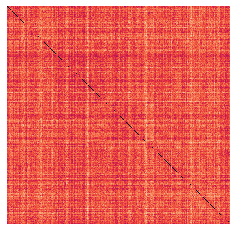

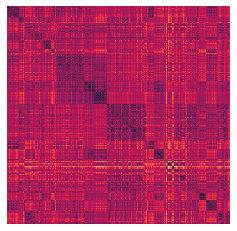

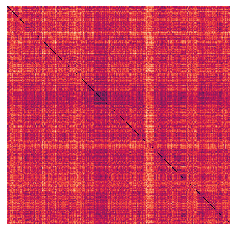

In [40]:
for i in range(3):
    plt.figure(figsize=(4,4))
    cmat = cmats[i]
    cmat = cmat/cmat.max()
    sns.heatmap(cmat,xticklabels=[],yticklabels=[],cbar=False)
    plt.savefig('/Users/aidasaglinskas/Desktop/bars/'+'rdm_' + xlbls[i] + '.png')

In [41]:
cmat/cmat.max()

array([[0.        , 0.54311535, 0.36007497, ..., 0.49505712, 0.35607737,
        0.57855414],
       [0.54311535, 0.        , 0.36593784, ..., 0.65354829, 0.54557121,
        0.54022383],
       [0.36007497, 0.36593784, 0.        , ..., 0.56511747, 0.42658107,
        0.53936796],
       ...,
       [0.49505712, 0.65354829, 0.56511747, ..., 0.        , 0.47215837,
        0.42421973],
       [0.35607737, 0.54557121, 0.42658107, ..., 0.47215837, 0.        ,
        0.56719797],
       [0.57855414, 0.54022383, 0.53936796, ..., 0.42421973, 0.56719797,
        0.        ]])

In [42]:
keys

dict_keys(['ADOS_Total', 'ADOS_Social', 'DSMIVTR', 'AgeAtScan', 'Sex', 'ScannerID', 'ScanSiteID', 'FIQ', 'ADOS_PCA', 'ADI_PCA', 'Vineland_PCA', 'WISC_PCA', 'best_full_scale_iq', 'rrb_css', 'sa_css', 'age_years', 'ord_diagnosis', 'ord_gene', 'ord_sex', 'ord_scanner'])

In [43]:
keys = list(rsa_results.keys())

key = keys[0]
data = rsa_results[key]
data = np.hstack((data,(data[:,2]-data[:,1])[:,np.newaxis]))
data = np.hstack((data,(data[:,1]-data[:,2])[:,np.newaxis]))

In [44]:
    pallete_new[1]=pallete[0]
    pallete_new[0]=pallete[1]
    pallete_new[0] = tuple(np.array((.5,.5,.5)))
    
n = data.shape[0]
c = data.shape[1]
x = np.arange(c)
for i in range(c):
        plot_data = np.zeros(data.shape)
        plot_data[:,i] = data[:,i]

        xs = np.repeat(i,n)+(np.random.rand(n)-.5)*.25
        sc = plt.scatter(xs,data[:,i],c='k',s = marker_size)
        b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))
        #sns.barplot(x=i,y=data.mean(axis=0)[i],errcolor='r',linewidth=2.5,facecolor=np.hstack((np.array(pallete_new[i]),.7)),edgecolor=np.hstack((np.array(pallete_new[i]),.7)))


NameError: name 'marker_size' is not defined

In [ ]:
keys = list(rsa_results.keys())

In [ ]:
keys = ['ADOS_Total',
 'ADOS_Social',
 'DSMIVTR',
 'AgeAtScan',
 'Sex',
 'ScannerID',
 'ScanSiteID',
 'FIQ',
 'ADOS_PCA',
 'ADI_PCA',
 'Vineland_PCA',
 'WISC_PCA']

keys = ['ADOS_Total',
 'ADOS_Social',
 'DSMIVTR',
 'AgeAtScan',
 'Sex',
 'ScannerID',
 'ScanSiteID',
 'FIQ',
 'ADOS_PCA',
 'ADI_PCA',
 'Vineland_PCA',
 'WISC_PCA']

In [ ]:
%matplotlib inline

keys_abide = ['ADOS_Total',
 'ADOS_Social',
 'DSMIVTR',
 'AgeAtScan',
 'Sex',
 'ScannerID',
 'ScanSiteID',
 'FIQ',
 'ADOS_PCA',
 'ADI_PCA',
 'Vineland_PCA',
 'WISC_PCA']

keys = keys_abide
## DATA
diffs = np.array([rsa_results[key][:,2]-rsa_results[key][:,1] for key in keys])
nkeys = diffs.shape[0]
ord_ = np.argsort(diffs.mean(axis=1))
diffs_sorted = diffs[ord_,:]
keys_sorted = np.array(keys)[ord_]
p_vals = np.array([scipy.stats.ttest_rel(rsa_results[key][:,2],rsa_results[key][:,1])[1] < .05/12 for key in keys])
t_vals = np.array([scipy.stats.ttest_rel(rsa_results[key][:,2],rsa_results[key][:,1])[0] for key in keys])
p_vals_sorted = p_vals[ord_]
t_vals_sorted = t_vals[ord_]



fig, ax = plt.subplots(1,1,figsize=np.array((2,5))*2.5)

pallete = sns.color_palette()
pallete_new = sns.color_palette()
pallete_new[1]=pallete[0];pallete_new[0]=pallete[1];pallete_new[0] = tuple(np.array((.5,.5,.5)))
bg_color = pallete_new[1]
sl_color = pallete_new[2]

linewidth = 3;fontsize = 14;fontweight='bold'
for idx,key in enumerate(keys):
    key = keys[idx]
    diff = diffs_sorted[idx,:]
    n = len(diff)
    m = diff.mean()
    sd = diff.std()
    
    #diff = abs(diff)
    if p_vals_sorted[idx] and (t_vals_sorted[idx]>0): # Significant Salient
        plt.barh(idx,m,facecolor=np.hstack((sl_color,.3)),edgecolor=np.hstack((sl_color,1)),linewidth=linewidth)
    elif p_vals_sorted[idx] and (t_vals_sorted[idx]<0): # Significant Background
        plt.barh(idx,m,facecolor=np.hstack((bg_color,.3)),edgecolor=np.hstack((bg_color,1)),linewidth=linewidth)
    else: # not significant
        plt.barh(idx,m,facecolor=[0,0,0,.1],edgecolor=[0,0,0,1],linewidth=linewidth)
        
    plt.scatter(x=diff,y=(np.repeat(idx,n)+(np.random.rand(n)-.5)*.25),c='k',s=50)
    
plt.yticks(np.arange(nkeys),labels=keys_sorted,fontsize=fontsize,fontweight=fontweight);
plt.xticks(fontsize=fontsize,fontweight=fontweight,rotation=45);
#plt.xlabel('model fit difference\nbackground      salient')

#ax.spines['top'].set_visible(False);
#ax.spines['right'].set_visible(False);
for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(linewidth);

In [ ]:
list(rsa_results.keys())

In [ ]:
%matplotlib inline

keys_abide = ['best_full_scale_iq',
 'age_years',
 'ord_diagnosis',
 'ord_gene',
 'ord_sex',
 'ord_scanner']

keys = keys_abide
## DATA
diffs = np.array([rsa_results[key][:,2]-rsa_results[key][:,1] for key in keys])
nkeys = diffs.shape[0]
ord_ = np.argsort(diffs.mean(axis=1))
diffs_sorted = diffs[ord_,:]
keys_sorted = np.array(keys)[ord_]
p_vals = np.array([scipy.stats.ttest_rel(rsa_results[key][:,2],rsa_results[key][:,1])[1] < .05/12 for key in keys])
t_vals = np.array([scipy.stats.ttest_rel(rsa_results[key][:,2],rsa_results[key][:,1])[0] for key in keys])
p_vals_sorted = p_vals[ord_]
t_vals_sorted = t_vals[ord_]


fig, ax = plt.subplots(1,1,figsize=np.array((2,5))*2.5)

pallete = sns.color_palette()
pallete_new = sns.color_palette()
pallete_new[1]=pallete[0];pallete_new[0]=pallete[1];pallete_new[0] = tuple(np.array((.5,.5,.5)))
bg_color = pallete_new[1]
sl_color = pallete_new[2]

linewidth = 3;fontsize = 14;fontweight='bold'
for idx,key in enumerate(keys):
    key = keys[idx]
    diff = diffs_sorted[idx,:]
    n = len(diff)
    m = diff.mean()
    sd = diff.std()
    
    #diff = abs(diff)
    if p_vals_sorted[idx] and (t_vals_sorted[idx]>0): # Significant Salient
        plt.barh(idx,m,facecolor=np.hstack((sl_color,.3)),edgecolor=np.hstack((sl_color,1)),linewidth=linewidth)
    elif p_vals_sorted[idx] and (t_vals_sorted[idx]<0): # Significant Background
        plt.barh(idx,m,facecolor=np.hstack((bg_color,.3)),edgecolor=np.hstack((bg_color,1)),linewidth=linewidth)
    else: # not significant
        plt.barh(idx,m,facecolor=[0,0,0,.1],edgecolor=[0,0,0,1],linewidth=linewidth)
        
    plt.scatter(x=diff,y=(np.repeat(idx,n)+(np.random.rand(n)-.5)*.25),c='k',s=50)
    
plt.yticks(np.arange(nkeys),labels=keys_sorted,fontsize=fontsize,fontweight=fontweight);
plt.xticks(fontsize=fontsize,fontweight=fontweight,rotation=45);
#plt.xlabel('model fit difference\nbackground      salient')

#ax.spines['top'].set_visible(False);
#ax.spines['right'].set_visible(False);
for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(linewidth);

In [ ]:
keys = list(model_idxs.keys())

In [ ]:
for key in keys:
    print(f'{key} | {model_idxs[key].sum()}'.rjust(25))

In [ ]:
import umap
from tqdm import tqdm
from sklearn.decomposition import PCA
patients = df['DxGroup'].values==1
reducer = umap.UMAP()
reducer = PCA(n_components=2)

In [ ]:
# # embedding = reducer.fit_transform(cmat_background_vec_abide[0,:,:][patients,:][:,patients])
# embedding = reducer.fit_transform(df['AgeAtScan'].values[patients].reshape(-1, 1) )
# plt.scatter(embedding[:,0],embedding[:,1])
# plt.title(key)

In [ ]:
rsa_results.keys()

In [ ]:
norm_arr = lambda sl_cmat : ((sl_cmat - sl_cmat.min()) / (sl_cmat.max()-sl_cmat.min()))

In [ ]:
sl_cmat = cmat_salient_vec_abide[0,:,:][patients,:][:,patients]
bg_cmat = cmat_background_vec_abide[0,:,:][patients,:][:,patients]
vae_cmat = cmat_vae_vec_abide[0,:,:][patients,:][:,patients]

# sl_cmat = norm_arr(sl_cmat)
# bg_cmat = norm_arr(bg_cmat)
# vae_cmat = norm_arr(vae_cmat)

In [ ]:
def make_RDM(inVec,data_scale='ratio',metric='euclidean'):
    vec = inVec
    #vec = (vec - min(vec.flatten())) / (max(vec.flatten())-min(vec.flatten()))
    
    if np.ndim(inVec)==1: # must be at least 2D
        vec = np.vstack((vec,np.zeros(vec.shape))).transpose()
                   
    mat = squareform(pdist(vec,metric=metric).transpose())
    
    #vec = (vec - min(vec)) / (max(vec)-min(vec))
    #mat = (mat - min(mat)) / (max(mat)-min(mat))

    if data_scale=='ordinal':
        mat[mat!=0]=1 # Make into zeros and ones
        
    return mat

In [ ]:
#vae_cmat[:,model_idxs[key]][model_idxs[key],:].max()


In [ ]:
import scipy

In [ ]:
keys

In [ ]:
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b

In [ ]:
fig = plt.figure(figsize=(15,5))
#key = 'AgeAtScan'
key = 'ADOS_Total'
#key = 'DSMIVTR'

v1 = df[key].values[patients][model_idxs[key]]
v_sl = scipy.linalg.norm(salient_vec_abide[0,:,:],axis=1)[patients][model_idxs[key]]
v_bg = scipy.linalg.norm(background_vec_abide[0,:,:],axis=1)[patients][model_idxs[key]]
v_vae = scipy.linalg.norm(vae_vec_abide[0,:,:],axis=1)[patients][model_idxs[key]]


plt.subplot(1,3,1)
plt.scatter(v1,v_sl)
plt.title('Salient')
plt.ylabel('distance in salient space')
plt.xlabel(f'Subject {key}')
#plt.xlim(0,triu_rdm.max());
plt.ylim(0,10)

a,b = best_fit(v1,v_sl)
yfit = [a + b * xi for xi in v1]
plt.plot(v1, yfit,'r',linewidth=2)


plt.subplot(1,3,2)
plt.scatter(v1,v_bg)
plt.title('Background')
plt.ylabel('distance in BG space')
plt.xlabel(f'Subject {key}')
#plt.xlim(0,triu_rdm.max());
plt.ylim(0,10)

a,b = best_fit(v1,v_bg)
yfit = [a + b * xi for xi in v1]
plt.plot(v1, yfit,'r',linewidth=2)

plt.subplot(1,3,3)
plt.scatter(v1,v_vae)
plt.title('VAE')
plt.ylabel('distance in VAE space')
plt.xlabel(f'Subject {key}')
#plt.xlim(0,triu_rdm.max())
plt.ylim(0,10)

a,b = best_fit(v1,v_vae)
yfit = [a + b * xi for xi in v1]
plt.plot(v1, yfit,'r',linewidth=2)


fig.suptitle(key, fontsize=14,y=1.08)

In [ ]:
#[np.corrcoef(v1,v)[0,1].round(3) for v in [v_sl,v_bg,v_vae]]

In [ ]:
fig = plt.figure(figsize=(15,5))
key = 'AgeAtScan'
rdm = make_RDM(df[key].values[patients][model_idxs[key]])
#rdm = model_rdms[key]
triu_rdm = get_triu(rdm)
plt.subplot(1,3,1)
#plt.scatter(triu_rdm,get_triu(sl_cmat[:,model_idxs[key]][model_idxs[key],:]),alpha=.1)
plt.title('Salient')
plt.ylabel('Subject distance in salient space')
plt.xlabel(f'Subject distance in {key}')
#plt.xlim(0,triu_rdm.max());plt.ylim(0,16)


plt.subplot(1,3,2)
plt.scatter(triu_rdm,get_triu(bg_cmat[:,model_idxs[key]][model_idxs[key],:]),alpha=.1)
plt.title('Background')
plt.ylabel('Subject distance in background space')
plt.xlabel(f'Subject distance in {key}')
#plt.xlim(0,triu_rdm.max());plt.ylim(0,16)

plt.subplot(1,3,3)
plt.scatter(triu_rdm,get_triu(vae_cmat[:,model_idxs[key]][model_idxs[key],:]),alpha=.1)
plt.title('VAE')
plt.ylabel('Subject distance in VAE space')
plt.xlabel(f'Subject distance in {key}')
#plt.xlim(0,triu_rdm.max());plt.ylim(0,16)

fig.suptitle(key, fontsize=14,y=1.08)

In [ ]:
keys

In [ ]:
fig = plt.figure(figsize=(15,5))
key = 'AgeAtScan'
#key = 'ADOS_Total'
rdm = make_RDM(df[key].values[patients][model_idxs[key]])
#rdm = model_rdms[key]
triu_rdm = get_triu(rdm)
plt.subplot(1,3,1)
plt.scatter(get_triu(sl_cmat[:,model_idxs[key]][model_idxs[key],:]),triu_rdm,alpha=.1)
plt.title('Salient')
plt.ylabel('Subject distance in salient space')
plt.xlabel(f'Subject distance in {key}')
#plt.xlim(0,triu_rdm.max());plt.ylim(0,16)


plt.subplot(1,3,2)
plt.scatter(get_triu(bg_cmat[:,model_idxs[key]][model_idxs[key],:]),triu_rdm,alpha=.1)
plt.title('Background')
plt.ylabel('Subject distance in background space')
plt.xlabel(f'Subject distance in {key}')
#plt.xlim(0,triu_rdm.max());plt.ylim(0,16)

plt.subplot(1,3,3)
plt.scatter(get_triu(vae_cmat[:,model_idxs[key]][model_idxs[key],:]),triu_rdm,alpha=.1)
plt.title('VAE')
plt.ylabel('Subject distance in VAE space')
plt.xlabel(f'Subject distance in {key}')
#plt.xlim(0,triu_rdm.max());plt.ylim(0,16)

fig.suptitle(key, fontsize=14,y=1.08)

In [ ]:
keys = ['ADOS_Total', 
        'ADOS_Social',
        'DSMIVTR', 
        'AgeAtScan',
        'Sex', 
        'ScannerID',
        'ScanSiteID',
        'FIQ', 
        'ADOS_PCA',
        'ADI_PCA', 
        'Vineland_PCA', 
        'WISC_PCA']


keys = ['ScannerID',
        'ScanSiteID',
        'AgeAtScan',
        'Sex', 
        'ADI_PCA',
        'FIQ',
        'ADOS_Total', 
        'ADOS_Social',
        'ADOS_PCA', 
        'DSMIVTR',
        'WISC_PCA',
        'Vineland_PCA', ]

nkeys = len(keys)

In [ ]:
list(rsa_results.keys())

In [ ]:
keys = ['ord_scanner',
       'age_years',
       'ord_sex',
       'best_full_scale_iq',
       'ord_diagnosis',
       'ord_gene']

In [ ]:
pallete = sns.color_palette()
pallete_new = sns.color_palette()
pallete_new[1]=pallete[0]
pallete_new[0]=pallete[1]
pallete_new[0] = tuple(np.array((.5,.5,.5)))

In [ ]:
%matplotlib inline
plt.figure(figsize=(15,5))
nkeys = len(keys)
for i in range(nkeys):
    key = keys[i]
    plot_data = rsa_results[key]
    for j in range(3):
        bw = .25
        x = [-bw,0,bw][j]
        x = x+i
        y = plot_data[:,j].mean()
        plt.bar(x,y,width=bw,alpha=.5,color=pallete_new[j])
        
plt.xticks(np.arange(nkeys),labels=keys);
plt.ylabel('kental tau')

# NEW BIG RSA

In [ ]:
keys = ['ADOS_Total', 
        'ADOS_Social',
        'DSMIVTR', 
        'AgeAtScan',
        'Sex', 
        'ScannerID',
        'ScanSiteID',
        'FIQ', 
        'ADOS_PCA',
        'ADI_PCA', 
        'Vineland_PCA', 
        'WISC_PCA']

keys = ['ADOS_Total', 
        'ADOS_Social',
        'DSMIVTR', 
        'AgeAtScan',
        'Sex', 
        'ScannerID',
        'ScanSiteID',
        'FIQ', 
        'ADOS_PCA',
        'ADI_PCA', 
        'WISC_PCA']

keys = ['ADOS_Total', 
        'AgeAtScan',
        'ScanSiteID']

data_scales = {'ADOS_Total' : 'ratio',
        'ADOS_Social' : 'ratio',
        'DSMIVTR' : 'ordinal',
        'AgeAtScan' : 'ratio',
        'Sex' : 'ordinal',
        'ScannerID' : 'ordinal',
        'ScanSiteID': 'ordinal',
        'FIQ' : 'ratio',
        'ADOS_PCA' : 'ratio',
        'ADI_PCA' :  'ratio',
        'WISC_PCA' : 'ratio'}

In [ ]:
# key1 = keys[0]
# key2 = keys[11]

nkeys = len(keys)
cmat = np.zeros((nkeys+3,nkeys+3))
for i in np.arange(nkeys):
    for j in np.arange(nkeys):
        key1 = keys[i]
        key2 = keys[j]

   #     print(key1)
   #     print(key2)
        union_idxs = np.intersect1d(np.nonzero(model_idxs[key1]),np.nonzero(model_idxs[key2]))

   #     print(model_idxs[key1].sum())
   #     print(model_idxs[key2].sum())

#         print(vec1.shape)
#         print(vec2.shape)

        rdm1 = make_RDM(df[key1].values[patients][union_idxs],data_scale=data_scales[key1])
        rdm2 = make_RDM(df[key2].values[patients][union_idxs],data_scale=data_scales[key1])

#         print(rdm1.shape)
#         print(rdm2.shape)

        corr = scipy.stats.stats.kendalltau
        r = corr(get_triu(rdm1),get_triu(rdm2))[0]
        
        if np.isnan(r):
            r = 0
            
        cmat[i,j] = r

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(cmat,annot=True,cbar=False)
lbls = np.hstack((np.array(keys),np.array(['VAE','SHARED','SALIENT']))) 
plt.xticks(np.arange(len(lbls))+.5,labels=lbls,rotation=45);
plt.yticks(np.arange(len(lbls))+.5,labels=lbls,rotation=0);

In [ ]:
# Correlation between Clinical and VAE
data = [cmat_vae_vec_abide,cmat_background_vec_abide,cmat_salient_vec_abide]

for v in np.arange(3):
    for k in np.arange(nkeys):
        key = keys[k]
        #print(key)

        idx = np.nonzero(model_idxs[key])[0]
        rdm1 = data[v][0,:,:][:,patients][patients,:][:,idx][idx,:]
        rdm2 = make_RDM(df[key].values[patients][model_idxs[key]],data_scale=data_scales[key])
        r = corr(get_triu(rdm1),get_triu(rdm2))[0]

        cmat[nkeys+v,k] = r
        cmat[k,nkeys+v] = r

In [ ]:
# Correlation between VAE
for v1 in np.arange(3):
    for v2 in np.arange(3):
        rdm1 = data[v1][0,:,:][:,patients][patients,:]
        rdm2 = data[v2][0,:,:][:,patients][patients,:]
        r = corr(get_triu(rdm1),get_triu(rdm2))[0]
        cmat[nkeys+v1,nkeys+v2] = r

In [ ]:
linkage = scipy.cluster.hierarchy.linkage
dendrogram = scipy.cluster.hierarchy.dendrogram

In [ ]:
plt.figure(figsize=(10,5))
Z = linkage(1-get_triu(cmat),'ward')
lbls = np.hstack((np.array(keys),np.array(['VAE','SHARED','SALIENT'])))
dendrogram(Z,0,labels=lbls,leaf_rotation=90);

In [ ]:
from sklearn import manifold
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=42,
                   dissimilarity="precomputed", n_jobs=1)

#pos = mds.fit(get_triu(cmat)).embedding_
pos = mds.fit(1-scipy.spatial.distance.squareform(get_triu(cmat))).embedding_


In [ ]:
plt.figure(figsize=(7,7))
for r in range(pos.shape[0]):
    plt.text(pos[r,0],pos[r,1],lbls[r],fontsize=16)
    
plt.xlim((min(pos[:,0]),max(pos[:,0])))
plt.ylim((min(pos[:,1]),max(pos[:,1])))

In [ ]:
# # SFARI FIT MODELS 
# data = [cmat_vae_vec_sfari,cmat_background_vec_sfari,cmat_salient_vec_sfari]
# #rsa_results = dict()
# for key in default_keys:
#     res = np.array([fit_rsa(datum,key) for datum in data]).transpose()
#     rsa_results.update({key : res})

In [ ]:
default_keys

In [ ]:
cmat_vae_vec_sfari.shape

# T-TABLE

In [205]:
from scipy import stats as stats
columns = ['key','VAE','BG','SL','SL>VAE','BG>VAE','SL>BG','BG>SL']
t_table = pd.DataFrame(np.zeros((len(keys),len(columns))),columns=columns)

In [221]:
def make_tstatement(vec,t,p,df,delta=False):
    if p < .001:
        t_statement = f'$\\tau$ = {vec.mean():.2f}, t({dg_f}) = {t:.2f}, p $<$ .001'
#         if delta==True:
#             t_statement = f'$\Delta\tau$ = {vec.mean():.2f}, t({dg_f}) = {t:.2f}, p $<$ .001'
    else:    
        t_statement = f'$\\tau$ = {vec.mean():.2f}, t({dg_f}) = {t:.2f}, p = {p:.3f}'
#         if delta==True:
#             t_statement = f'$\Delta\tau$ = {vec.mean():.2f}, t({dg_f}) = {t:.2f}, p $<$ .001'

    if delta==True:
        t_statement = t_statement.replace('$\\tau$','$\\Delta\\tau$')
    return t_statement

In [222]:
%%capture
keys = list(rsa_results.keys())
key = keys[0]


dg_f = datum.shape[0]-1

for i,key in enumerate(keys):
    datum = rsa_results[key]
    t_table['key'][i] = key
    
    t,p = stats.ttest_1samp(datum[:,0],0)
    t_table['VAE'][i] = make_tstatement(datum[:,0],t,p,df)
    #print(make_tstatement(t,p,df))

    t,p = stats.ttest_1samp(datum[:,1],0)
    t_table['BG'][i] = make_tstatement(datum[:,1],t,p,df)

    t,p = stats.ttest_1samp(datum[:,2],0)
    t_table['SL'][i] = make_tstatement(datum[:,2],t,p,df)

    t,p = stats.ttest_rel(datum[:,2],datum[:,0])
    t_table['SL>VAE'][i] = make_tstatement(datum[:,2]-datum[:,0],t,p,df,delta=True)

    t,p = stats.ttest_rel(datum[:,1],datum[:,0])
    t_table['BG>VAE'][i] = make_tstatement(datum[:,1]-datum[:,0],t,p,df,delta=True)
    #print(make_tstatement(t,p,df))

    t,p = stats.ttest_rel(datum[:,2],datum[:,1])
    t_table['SL>BG'][i] = make_tstatement(datum[:,2]-datum[:,1],t,p,df,delta=True)
    
    t,p = stats.ttest_rel(datum[:,1],datum[:,2])
    t_table['BG>SL'][i] = make_tstatement(datum[:,1]-datum[:,2],t,p,df,delta=True)


In [223]:
t_table.to_csv('../Results/t_table.csv',encoding='utf-8')

In [213]:
t_table.head()

,key,VAE,BG,SL,SL>VAE,BG>VAE,SL>BG,BG>SL
0,ADOS_Total,"$\tau$ = -0.00, t(9) = -0.57, p = 0.582","$\tau$ = -0.00, t(9) = -1.50, p = 0.167","$\tau$ = 0.01, t(9) = 16.85, p $<$ .001","$\Delta\tau$ = 0.01, t(9) = 2.41, p = 0.039","$\Delta\tau$ = 0.00, t(9) = 0.33, p = 0.746","$\Delta\tau$ = 0.01, t(9) = 11.59, p $<$ .001","$\Delta\tau$ = -0.01, t(9) = -11.59, p $<$ .001"
1,ADOS_Social,"$\tau$ = -0.00, t(9) = -0.04, p = 0.971","$\tau$ = 0.00, t(9) = 0.03, p = 0.975","$\tau$ = 0.01, t(9) = 9.50, p $<$ .001","$\Delta\tau$ = 0.01, t(9) = 2.10, p = 0.066","$\Delta\tau$ = 0.00, t(9) = 0.04, p = 0.966","$\Delta\tau$ = 0.01, t(9) = 8.64, p $<$ .001","$\Delta\tau$ = -0.01, t(9) = -8.64, p $<$ .001"
2,DSMIVTR,"$\tau$ = 0.02, t(9) = 2.15, p = 0.060","$\tau$ = 0.02, t(9) = 29.02, p $<$ .001","$\tau$ = 0.06, t(9) = 30.83, p $<$ .001","$\Delta\tau$ = 0.04, t(9) = 5.15, p $<$ .001","$\Delta\tau$ = 0.00, t(9) = 0.29, p = 0.777","$\Delta\tau$ = 0.04, t(9) = 20.04, p $<$ .001","$\Delta\tau$ = -0.04, t(9) = -20.04, p $<$ .001"
3,AgeAtScan,"$\tau$ = 0.02, t(9) = 4.63, p = 0.001","$\tau$ = 0.08, t(9) = 89.29, p $<$ .001","$\tau$ = 0.05, t(9) = 48.60, p $<$ .001","$\Delta\tau$ = 0.03, t(9) = 6.81, p $<$ .001","$\Delta\tau$ = 0.06, t(9) = 15.21, p $<$ .001","$\Delta\tau$ = -0.03, t(9) = -24.11, p $<$ .001","$\Delta\tau$ = 0.03, t(9) = 24.11, p $<$ .001"
4,Sex,"$\tau$ = 0.02, t(9) = 2.74, p = 0.023","$\tau$ = 0.05, t(9) = 35.34, p $<$ .001","$\tau$ = 0.02, t(9) = 8.13, p $<$ .001","$\Delta\tau$ = -0.00, t(9) = -0.35, p = 0.731","$\Delta\tau$ = 0.03, t(9) = 3.23, p = 0.010","$\Delta\tau$ = -0.03, t(9) = -11.90, p $<$ .001","$\Delta\tau$ = 0.03, t(9) = 11.90, p $<$ .001"


In [ ]:
# keys = list(model_rdms.keys())
# for key in ['ADOS_Total','AgeAtScan','ScannerID']:
#     plt.figure()
#     bigData = model_rdms[key]
#     #sns.heatmap(model_rdms[key])
#     embedding = reducer.fit_transform(bigData)
#     plt.scatter(embedding[:,0],embedding[:,1])
#     plt.title(key)